# Classificações de emoções em imagens

Este projeto tem o objetivo de fazer experimentos de treinamento de modelo de classificação de emoções em imagens estáticas, utilizando o dataset FER-2013 e o modelo pré treinado VGG19.
O objetivo é alcançar mais de 90% de acurácia no dataset de testes, além de comparar outras métricas utilizadas em outros estudos, como F1-score, matriz de confusão e recall.

## 1. Baixando o modelo de detecção de faces

In [ ]:
import urllib.request
import bz2

# Baixa o arquivo
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
urllib.request.urlretrieve(url, "shape_predictor_68_face_landmarks.dat.bz2")

# Descompacta o arquivo
with open("shape_predictor_68_face_landmarks.dat", "wb") as f:
    with bz2.open("shape_predictor_68_face_landmarks.dat.bz2", "rb") as bz2_file:
        f.write(bz2_file.read())

## 2. Importação de bibliotecas que serão utilizadas no projeto

In [1]:
# Manipulação de dados
import numpy as np
import pandas as pd
import os
import zipfile
import shutil

# Processamento de imagens
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imutils import face_utils
import dlib

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning com Keras/TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import kagglehub
from IPython.display import display, Markdown

# Supress warnings
import warnings
warnings.filterwarnings('ignore')


C:\Users\Igor Cenzi\anaconda3.10\envs\tcc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Nesta etapa é feito o download do dataset FER-2013 com o kagglehub

In [2]:
destination_path = "./fer2013"

In [3]:

# Baixar o dataset
kaggle_path = kagglehub.dataset_download("msambare/fer2013")

# Copiar os arquivos baixados para a pasta destino
if not os.path.exists(destination_path):
    shutil.copytree(kaggle_path, destination_path)

print("Dataset copiado para:", destination_path)

Dataset copiado para: ./fer2013


## 4. Carregando os dados baixados para a memória

In [3]:
# Caminhos
train_path = os.path.join(destination_path, "train")
test_path = os.path.join(destination_path, "test")

# Função para carregar imagens e labels
def load_images_and_labels(data_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_path))  # garantir ordem consistente
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)  # Lê como BGR (3 canais)
            if img is not None:
                images.append(img)
                labels.append(label_map[class_name])

    return np.array(images), np.array(labels), label_map

# Carrega treino e teste
X_train, y_train, label_map = load_images_and_labels(train_path)
X_test, y_test, _ = load_images_and_labels(test_path)

# Informações básicas
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Labels mapeadas:", label_map)

Train: (50800, 48, 48, 3) (50800,)
Test: (7178, 48, 48, 3) (7178,)
Labels mapeadas: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## 5. Visualizando algumas imagens de cada uma das 7 classes do dataset

### Angry:

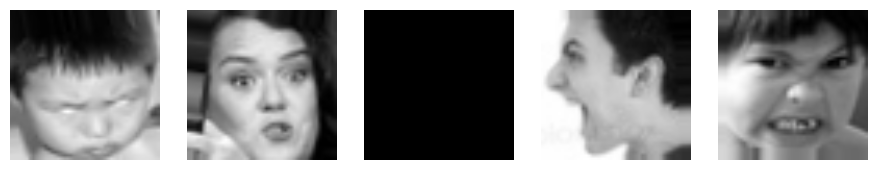

### Disgust:

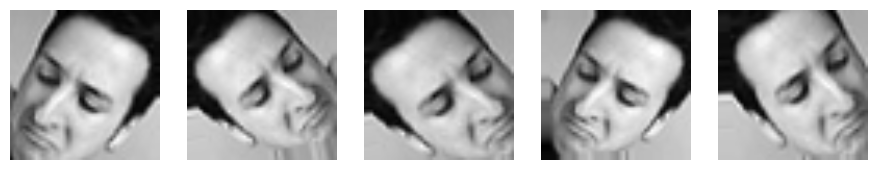

### Fear:

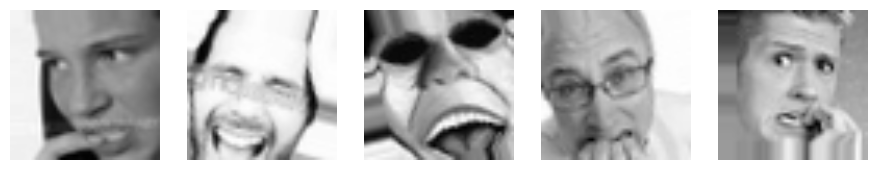

### Happy:

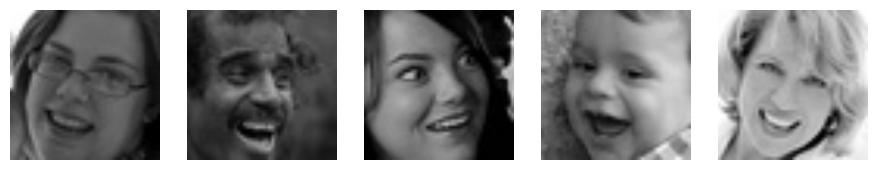

### Neutral:

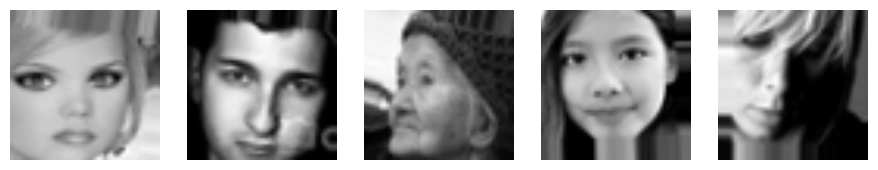

### Sad:

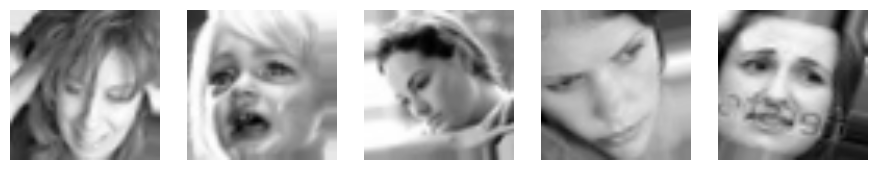

### Surprise:

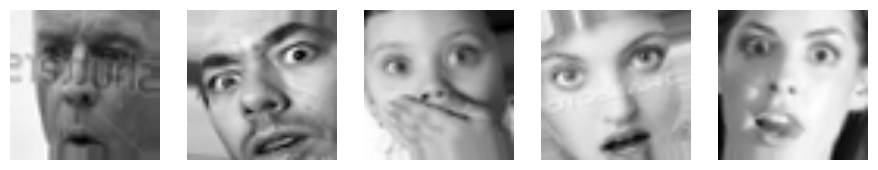

In [6]:
# Inverter o mapeamento numérico para nome da classe
inv_label_map = {v: k for k, v in label_map.items()}

# Número de imagens por classe
samples_per_class = 5
classes = sorted(np.unique(y_train))
selected_images = {label: [] for label in classes}

# Coleta até 5 imagens por classe
for img, label in zip(X_train, y_train):
    if len(selected_images[label]) < samples_per_class:
        selected_images[label].append(img)
    if all(len(imgs) == samples_per_class for imgs in selected_images.values()):
        break

# Exibir uma linha por classe
for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name}:"))

    fig, axes = plt.subplots(1, samples_per_class, figsize=(samples_per_class * 1.8, 1.8))
    for i in range(samples_per_class):
        img_rgb = cv2.cvtColor(selected_images[label][i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb, interpolation='bilinear')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## 6. Visualizando algumas métricas do dataset de treino e comparando com o dataset de teste

Aqui podemos ver como o conjunto de treino é bem similar ao de teste, a porcentagem que cada classe é representada é praticamente a mesma.

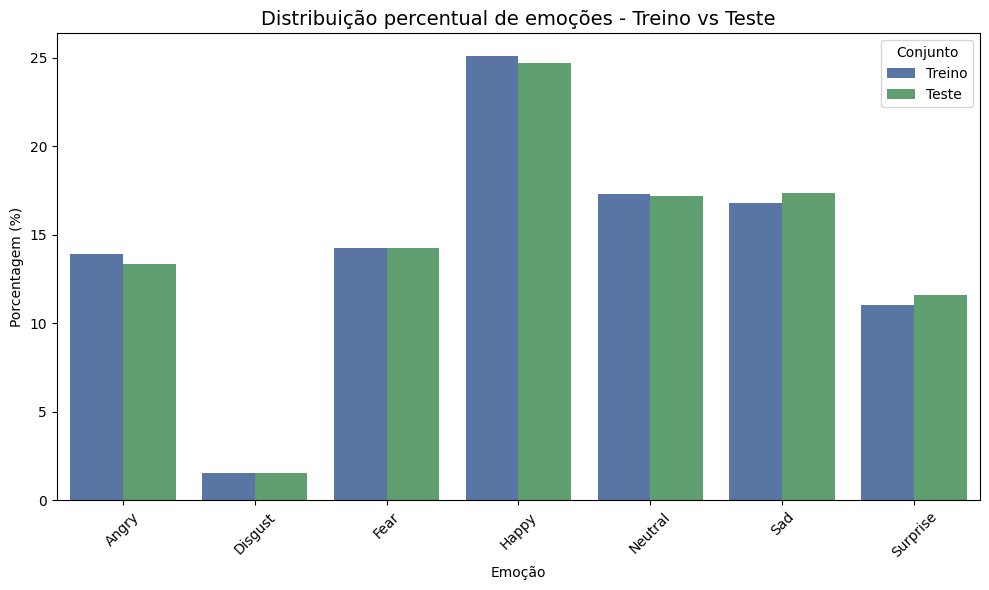

In [8]:
# Reaproveitar a função de distribuição
def get_distribution(labels):
    count_series = pd.Series(labels).value_counts().sort_index()
    count_df = pd.DataFrame({
        'Emoção': [inv_label_map[i].capitalize() for i in count_series.index],
        'Quantidade': count_series.values,
    })
    total = count_df['Quantidade'].sum()
    count_df['Porcentagem'] = (count_df['Quantidade'] / total * 100).round(2)
    return count_df

# Obter distribuições
df_train = get_distribution(y_train)
df_test = get_distribution(y_test)

# Adicionar coluna para identificar o tipo de conjunto
df_train['Conjunto'] = 'Treino'
df_test['Conjunto'] = 'Teste'

# Combinar os dois dataframes
df_combined = pd.concat([df_train, df_test])

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_combined,
    x='Emoção',
    y='Porcentagem',
    hue='Conjunto',
    palette=['#4C72B0', '#55A868']
)

plt.title("Distribuição percentual de emoções - Treino vs Teste", fontsize=14)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Emoção")
plt.xticks(rotation=45)
plt.legend(title="Conjunto")
plt.tight_layout()
plt.show()

## 7. Funções para a pipeline

O próximo passo é escrever funções para o pré processamento das imagens, para criar uma pipeline que irá ser utilizada para processar as imagens antes do modelo prever o resultado.
Isso ajuda a garantir que as imagens de treino terão as mesmas condições das imagens de produção.

In [4]:
def to_rgb(image):
    """Converte imagem para RGB se estiver em grayscale."""
    if len(image.shape) == 2 or image.shape[2] == 1:
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [5]:
# Carrega o classificador HaarCascade frontal padrão (incluso no OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(image, scaleFactor=1.1, minNeighbors=5):
    """Detecta o rosto e retorna apenas a região do rosto. Se não detectar, retorna a imagem original."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    if len(faces) == 0:
        return image  # Nenhum rosto encontrado

    # Pega a maior detecção (mais comum em fotos reais com um rosto só)
    x, y, w, h = max(faces, key=lambda box: box[2] * box[3])
    cropped = image[y:y+h, x:x+w]
    return cropped


In [6]:
def resize_image(image, size=(224, 224)):
    """Redimensiona a imagem para o tamanho indicado."""
    return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)


In [7]:
def normalize_pixels(image):
    """Normaliza os valores de pixel para o intervalo [0, 1]."""
    return image.astype(np.float32) / 255.0


In [8]:
def equalize_histogram(image):
    """Aplica equalização de histograma nos 3 canais RGB separadamente."""
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return equalized


In [9]:
# Inicializar os detectores GLOBALMENTE (fora da função)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def align_face_landmarks(image, label=None):
    """Alinha o rosto usando pontos faciais com tratamento especial para ângulos próximos a 180°"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    if len(rects) == 0:
        return image

    rect = max(rects, key=lambda r: r.width() * r.height())
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]

    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX))

    # Ajuste especial para ângulos próximos a 180°
    if angle > 150:  # Consideramos como rotação invertida
        angle = angle - 180
    elif angle < -150:
        angle = angle + 180

    rotation_angle = angle  # Já ajustamos o ângulo

    if label is not None:
        print(f"Label: {label}, Original angle: {np.degrees(np.arctan2(dY, dX)):.2f}, Adjusted angle: {angle:.2f}, Rotation to apply: {rotation_angle:.2f}")

    if abs(rotation_angle) > 45:
        return image

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    aligned_image = cv2.warpAffine(image, rot_matrix, (w, h),
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return aligned_image

## 7.1 Visualização das imagens rotacionadas
Aqui temos apenas uma visualização para comparar as imagens antes e depois do tratamento de rotação da face

Label: Angry, Original angle: 173.29, Adjusted angle: -6.71, Rotation to apply: -6.71
Label: Disgust, Original angle: -154.98, Adjusted angle: 25.02, Rotation to apply: 25.02
Label: Disgust, Original angle: -168.11, Adjusted angle: 11.89, Rotation to apply: 11.89
Label: Disgust, Original angle: 137.49, Adjusted angle: 137.49, Rotation to apply: 137.49
Label: Fear, Original angle: -165.96, Adjusted angle: 14.04, Rotation to apply: 14.04
Label: Fear, Original angle: -170.54, Adjusted angle: 9.46, Rotation to apply: 9.46
Label: Happy, Original angle: -162.65, Adjusted angle: 17.35, Rotation to apply: 17.35
Label: Happy, Original angle: 180.00, Adjusted angle: 0.00, Rotation to apply: 0.00
Label: Happy, Original angle: 166.76, Adjusted angle: -13.24, Rotation to apply: -13.24
Label: Happy, Original angle: -175.91, Adjusted angle: 4.09, Rotation to apply: 4.09
Label: Happy, Original angle: -164.05, Adjusted angle: 15.95, Rotation to apply: 15.95
Label: Neutral, Original angle: 177.27, Adjus

### Angry — Antes e Depois da Rotação (Landmarks):

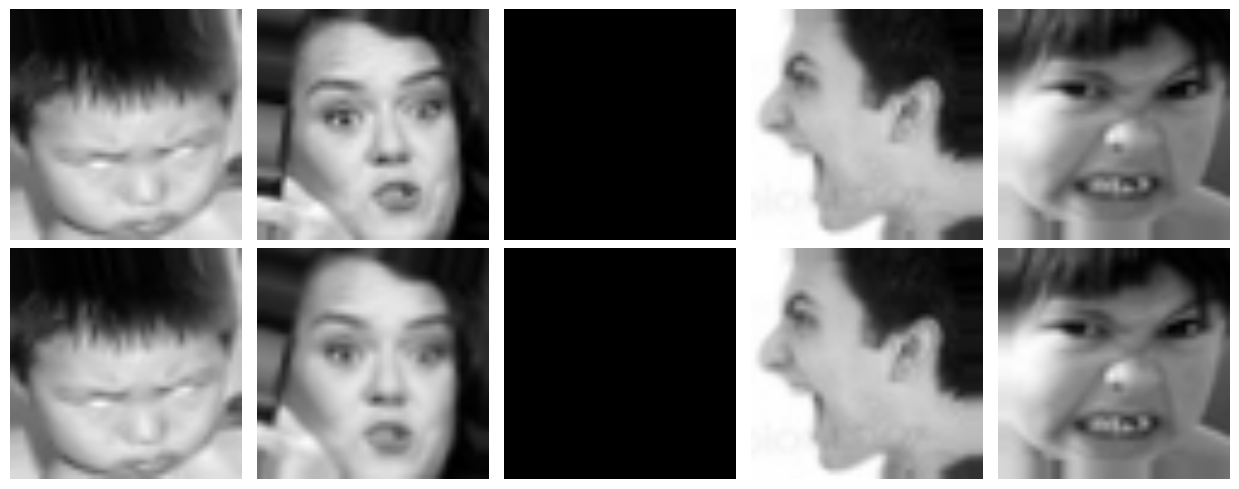

### Disgust — Antes e Depois da Rotação (Landmarks):

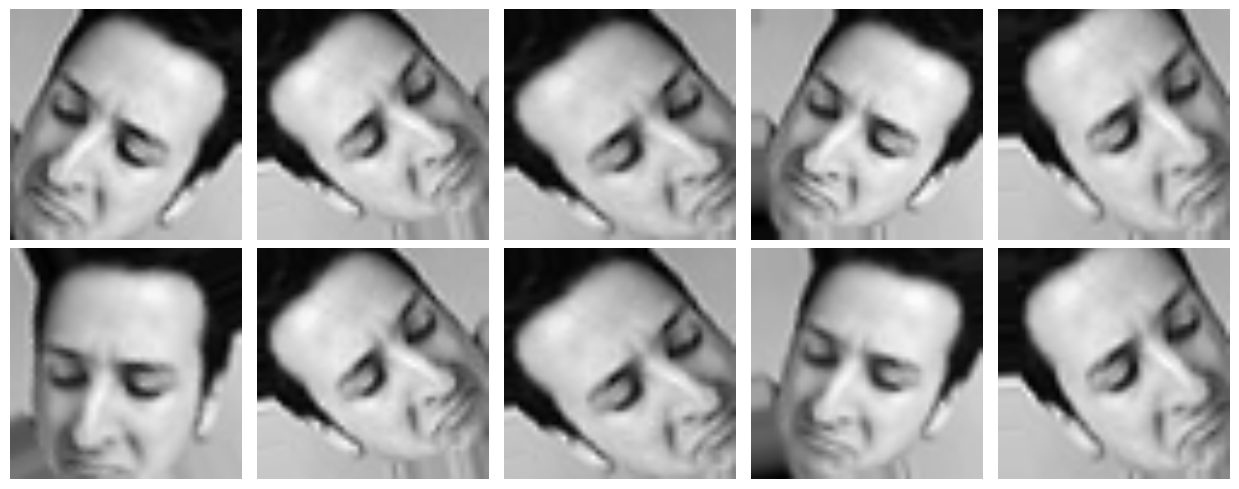

### Fear — Antes e Depois da Rotação (Landmarks):

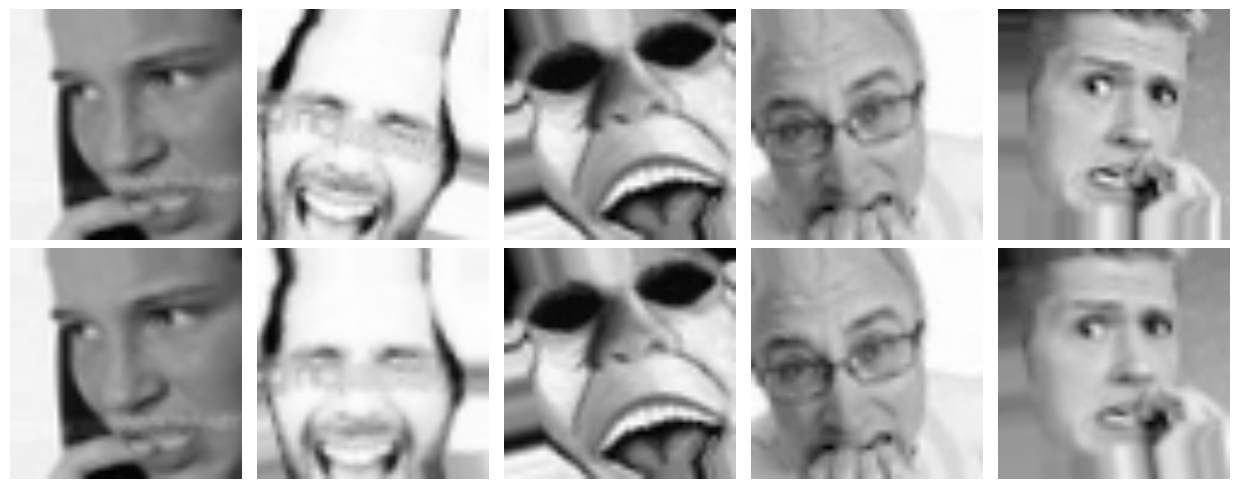

### Happy — Antes e Depois da Rotação (Landmarks):

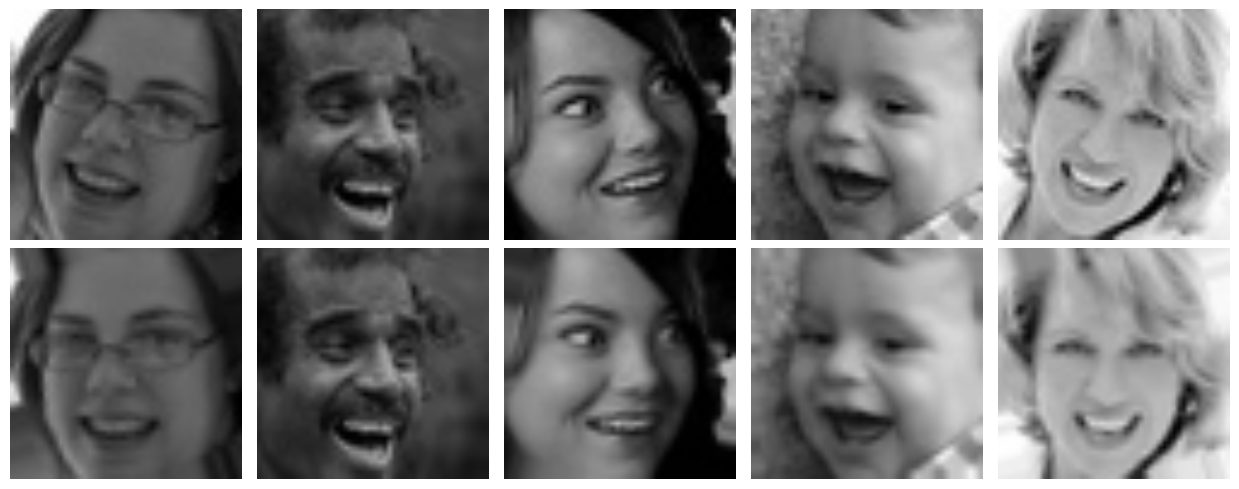

### Neutral — Antes e Depois da Rotação (Landmarks):

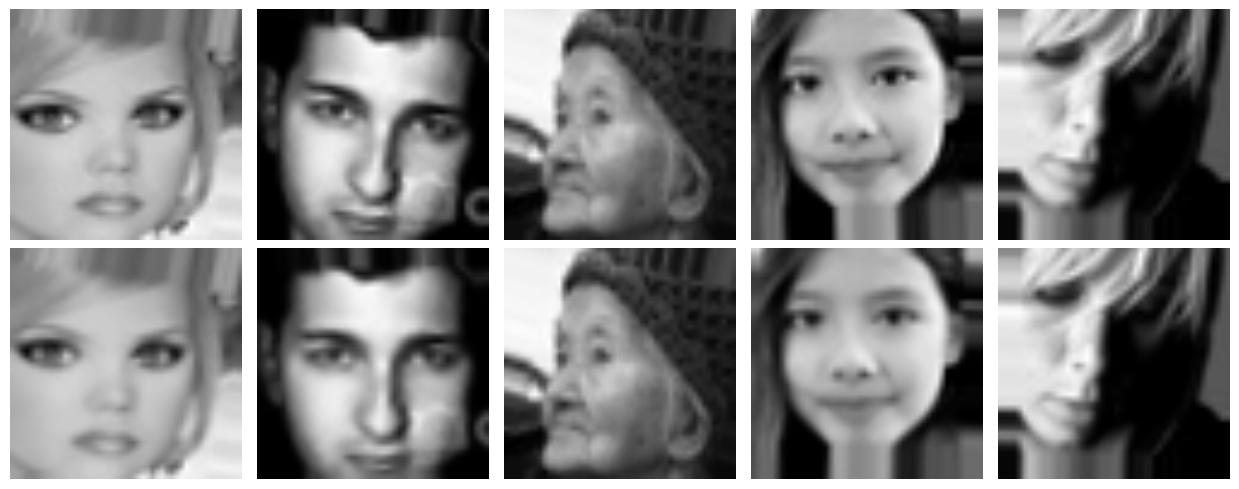

### Sad — Antes e Depois da Rotação (Landmarks):

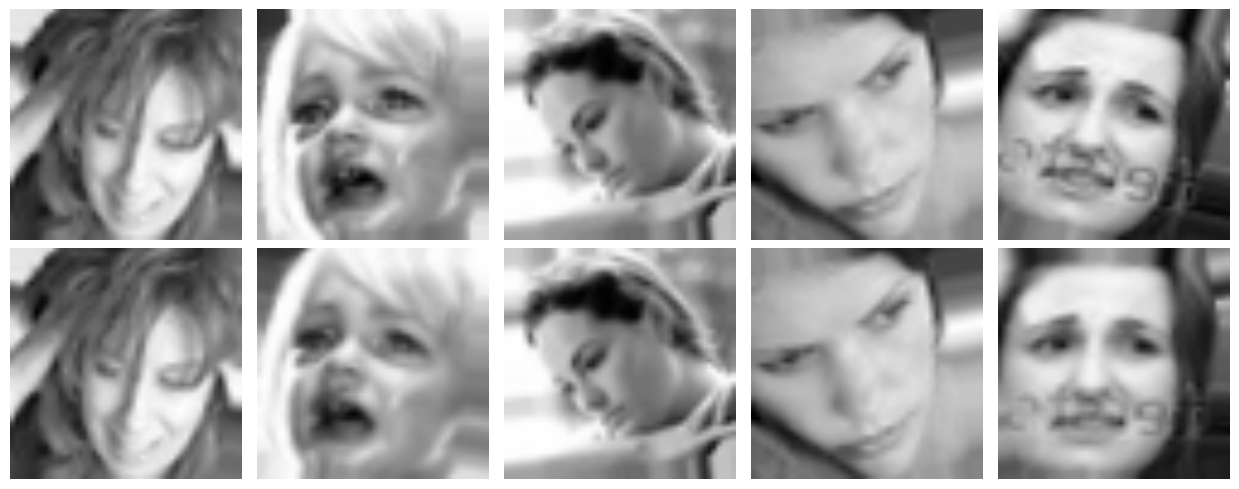

### Surprise — Antes e Depois da Rotação (Landmarks):

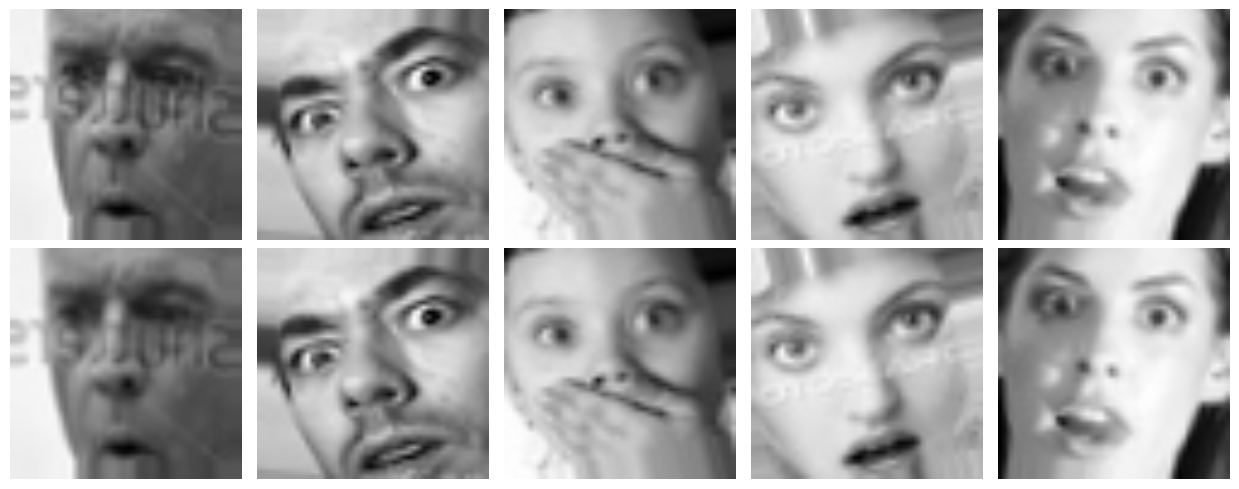

In [13]:
# Aplica o alinhamento baseado em landmarks nas imagens selecionadas
aligned_images_landmarks = {}

for label in classes:
    aligned_images_landmarks[label] = []
    for img in selected_images[label]:
        emotion_name = inv_label_map[label].capitalize()
        aligned = align_face_landmarks(img, label=emotion_name)
        aligned_images_landmarks[label].append(aligned)

# Exibir original x rotacionado lado a lado
for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name} — Antes e Depois da Rotação (Landmarks):"))

    fig, axes = plt.subplots(2, samples_per_class, figsize=(samples_per_class * 2.5, 5))

    for i in range(samples_per_class):
        # Linha 1: Original
        original_img = cv2.cvtColor(selected_images[label][i], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(original_img, interpolation='bilinear')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)

        # Linha 2: Alinhado
        aligned_img = cv2.cvtColor(aligned_images_landmarks[label][i], cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(aligned_img, interpolation='bilinear')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel("Alinhado", fontsize=12)

    plt.tight_layout()
    plt.show()

## 8. Criação de pipeline para tratamento das imagens

In [10]:
def preprocess_pipeline(image, apply_equalization=False):
    """
    Aplica a sequência completa de pré-processamento:
    1. Conversão para RGB
    2. Alinhamento baseado em landmarks (dlib)
    3. Detecção e recorte do rosto (HaarCascade)
    4. Redimensionamento para 224x224
    5. (Opcional) Equalização de histograma
    6. Normalização dos pixels para [0, 1]

    Retorna a imagem pronta para entrada na rede neural.
    """

    # 1. Garantir que está em RGB
    image = to_rgb(image)

    # 2. Alinhamento facial com landmarks
    image = align_face_landmarks(image)

    # 3. Recorte do rosto (HaarCascade)
    image = detect_and_crop_face(image)

    # 4. Redimensionamento
    image = resize_image(image, size=(224, 224))

    # 5. Equalização de histograma (opcional)
    if apply_equalization:
        image = equalize_histogram(image)

    # 6. Normalização
    image = normalize_pixels(image)

    return image

## 8.1 Visualização das imagens processadas
Aqui temos apenas uma visualização para comparar as imagens antes e depois da aplicação da pipeline

### Angry — Antes e Depois do Pré-processamento:

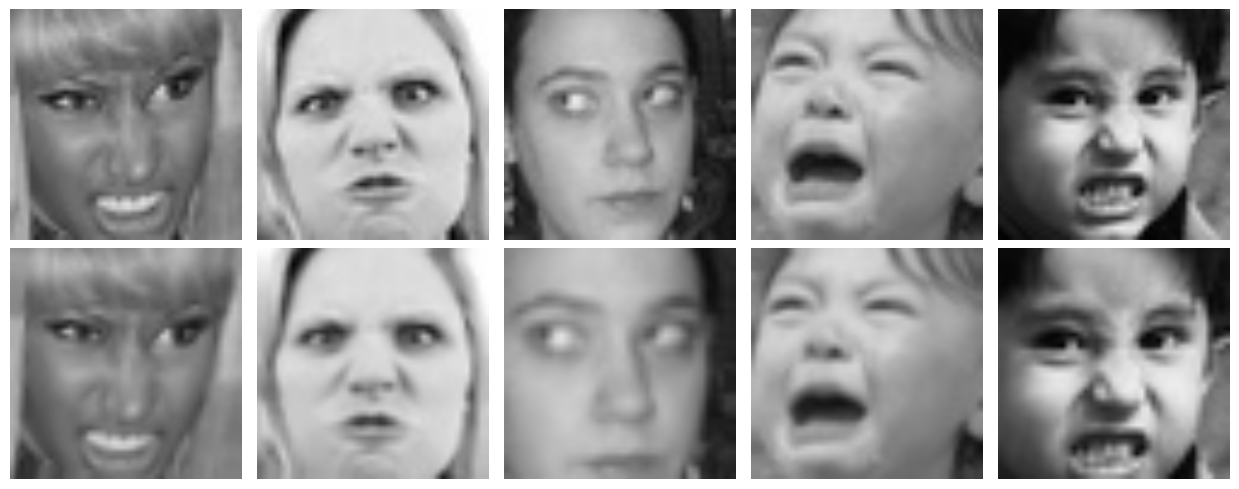

### Disgust — Antes e Depois do Pré-processamento:

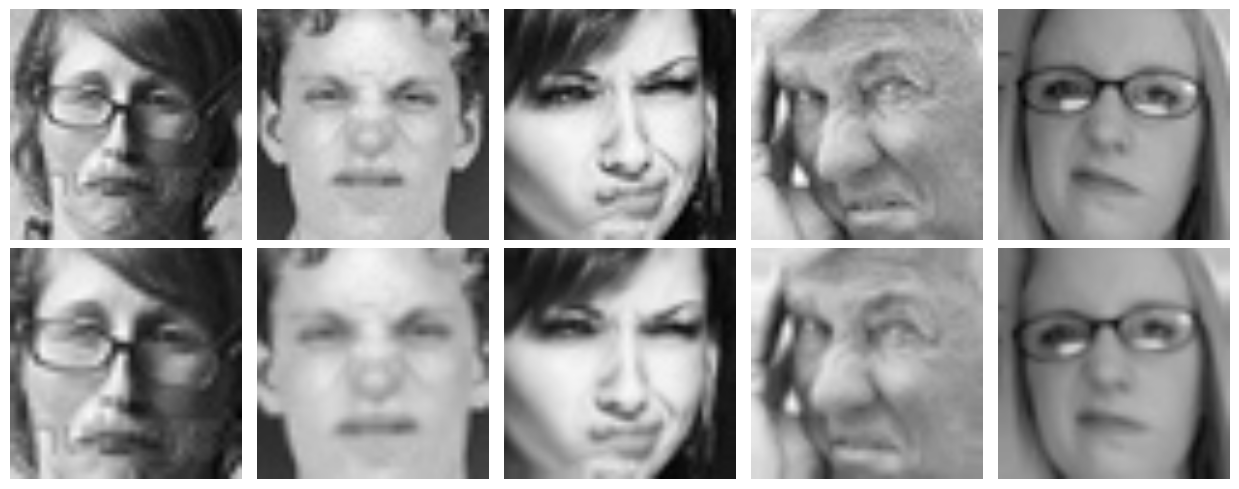

### Fear — Antes e Depois do Pré-processamento:

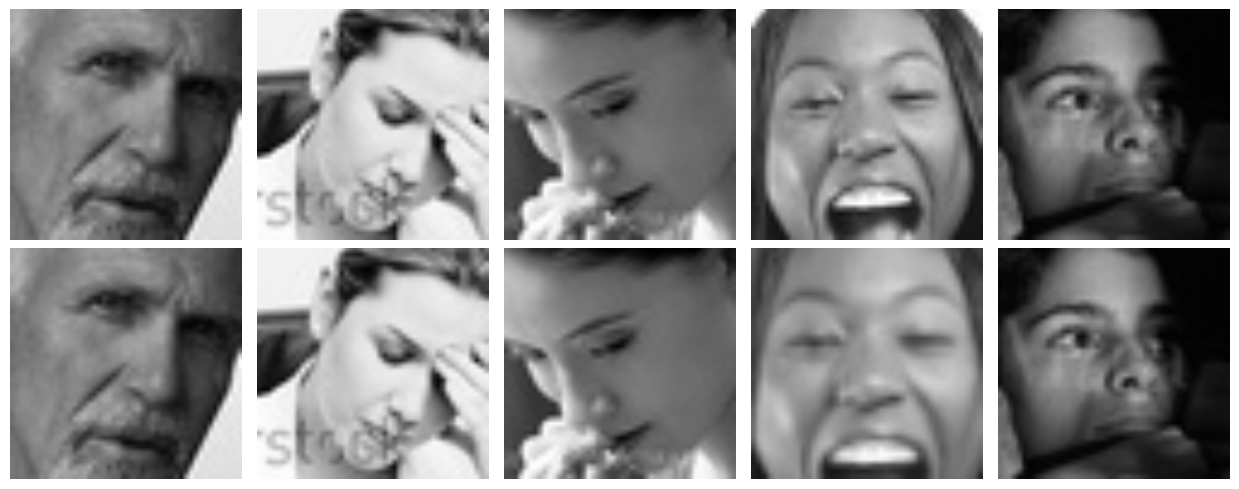

### Happy — Antes e Depois do Pré-processamento:

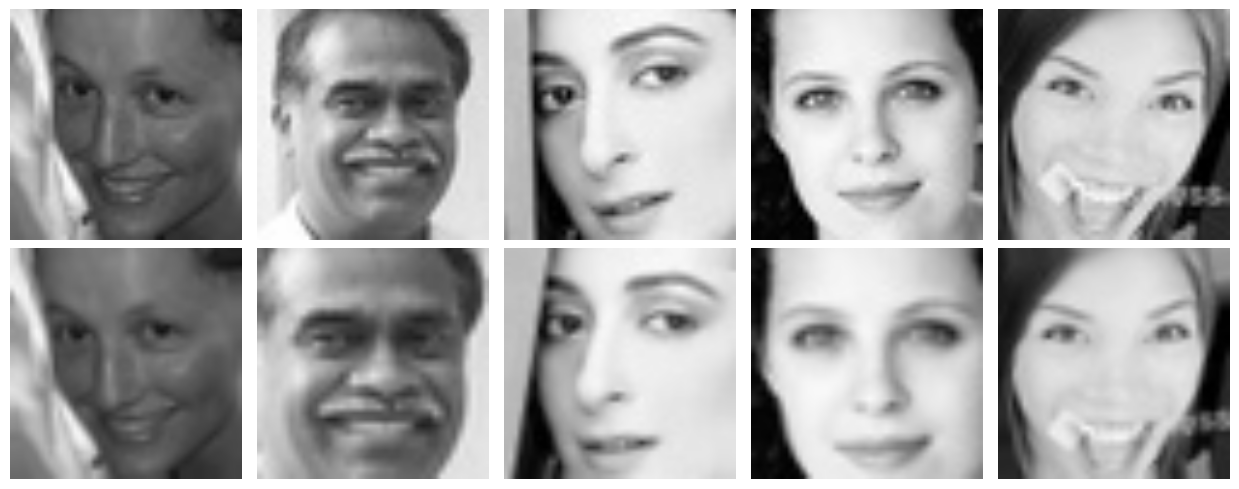

### Neutral — Antes e Depois do Pré-processamento:

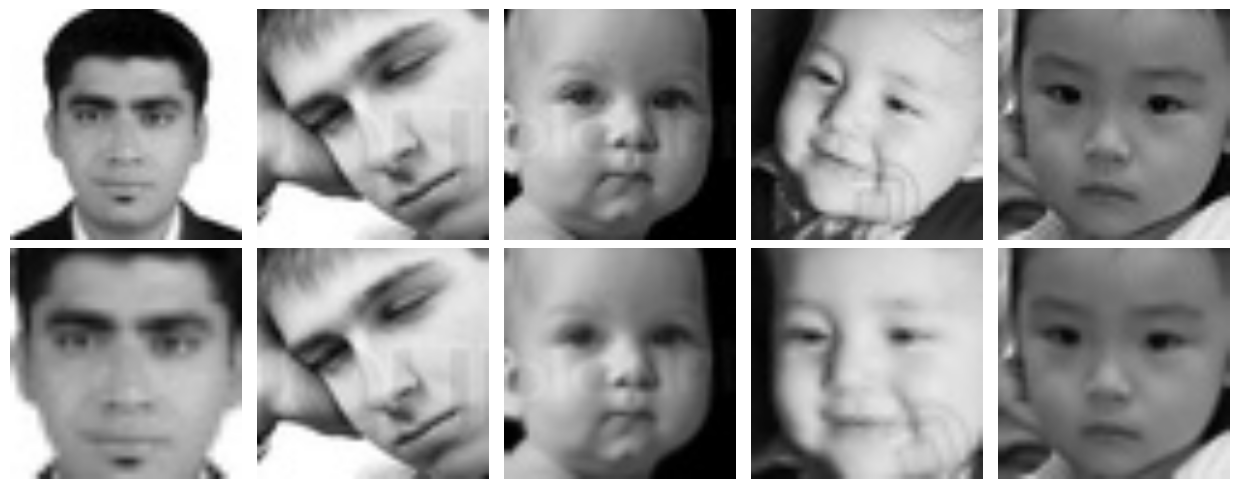

### Sad — Antes e Depois do Pré-processamento:

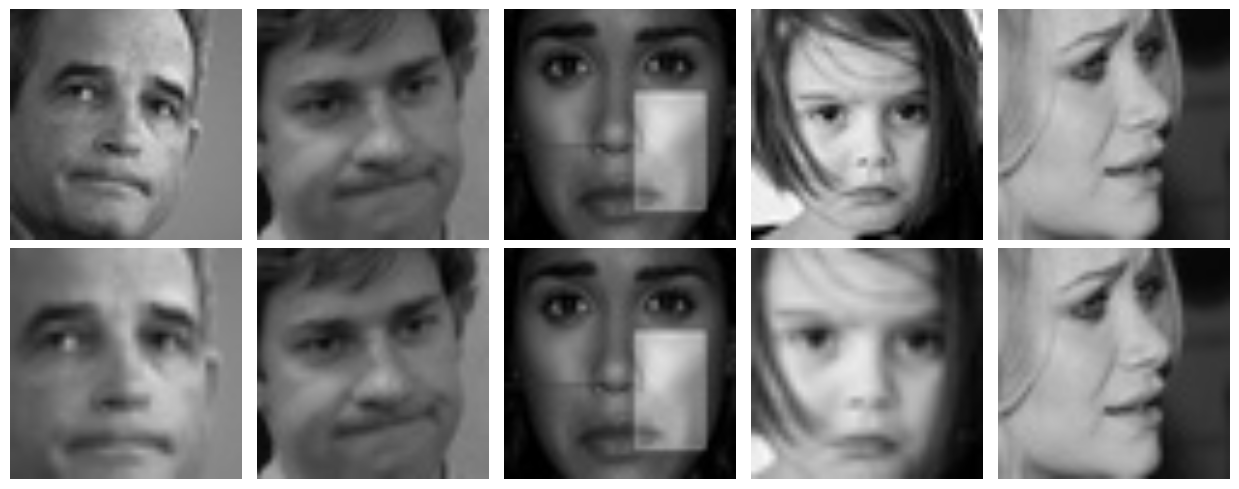

### Surprise — Antes e Depois do Pré-processamento:

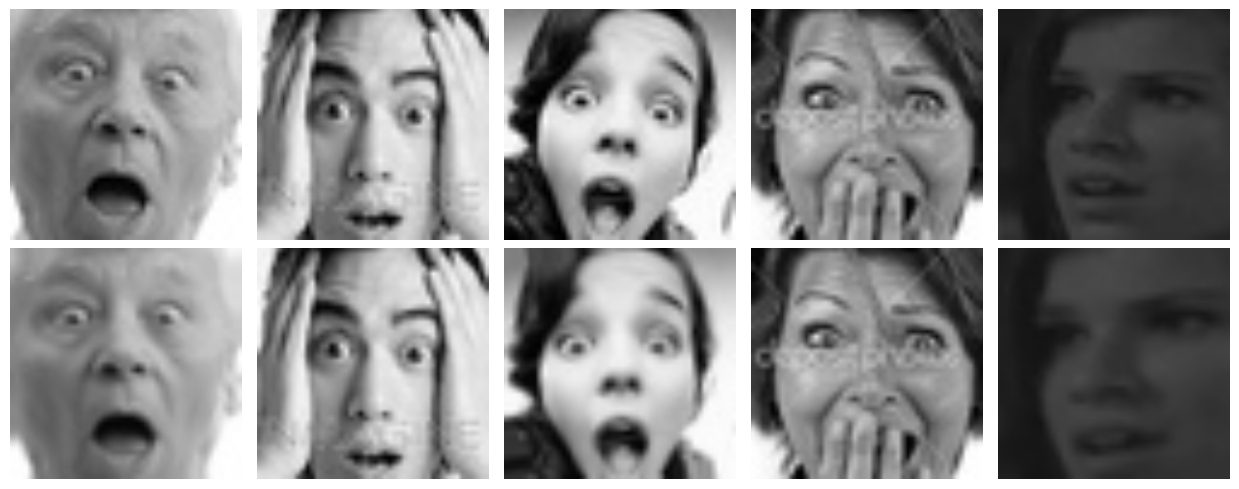

In [15]:
# Selecionar as últimas 5 imagens por classe
final_samples = 5
final_images = {label: [] for label in classes}

# Percorrer o dataset reverso para pegar as últimas imagens
for img, label in zip(reversed(X_train), reversed(y_train)):
    if len(final_images[label]) < final_samples:
        final_images[label].append(img)
    if all(len(imgs) == final_samples for imgs in final_images.values()):
        break

# Aplicar o pré-processamento
processed_images = {}

for label in classes:
    processed_images[label] = []
    for img in final_images[label]:
        processed = preprocess_pipeline(img)  # pode passar apply_equalization=True se quiser
        processed_images[label].append(processed)

# Exibir comparativo antes e depois
for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name} — Antes e Depois do Pré-processamento:"))

    fig, axes = plt.subplots(2, final_samples, figsize=(final_samples * 2.5, 5))

    for i in range(final_samples):
        # Antes
        original = cv2.cvtColor(final_images[label][i], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(original, interpolation='bilinear')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)

        # Depois
        after = processed_images[label][i]
        after = np.clip(after * 255, 0, 255).astype(np.uint8)  # converter para visualização
        axes[1, i].imshow(after, interpolation='bilinear')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel("Processado", fontsize=12)

    plt.tight_layout()
    plt.show()


## 9. Treinamento do modelo
Nesta etapa é criado o modelo e treinamento do mesmo.

In [11]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = len(label_map)
BATCH_SIZE = 32
EPOCHS = 20

## 9.1 Transformar as imagens em array
Primeiro passamos as imagens de treino e teste pela pipeline de pré processamento.
Em seguida, é convertida para array utilizando o np.array.
Após isso, convertemos os dados das labels em categorias utilizando a técnica one-hot, pois a ultima camada do VGG19 terá o mesmo número de categorias.

In [12]:
# Transformar X e y em arrays e converter labels para one-hot
X_train_proc = np.array([preprocess_pipeline(img) for img in X_train])
X_test_proc = np.array([preprocess_pipeline(img) for img in X_test])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)

Train shape: (50800, 224, 224, 3)
Test shape: (7178, 224, 224, 3)


## 9.2 Configuração da rede neural
O modelo base é o VGG19. A princípio, vamos congelar as camadas convolucionais para não alterar os pesos e ver como se comporta
Incluimos camadas finais customizadas que serão traináveis.
Na camada final, colocamos a quantidade de classes que temos para prever.

In [20]:
# Carrega a base do VGG19 sem a camada de classificação final
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congela as camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Adiciona as camadas finais customizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 9.3 Treinamento
Nesta etapa começamos o treinamento com o conjunto de treino e vemos como ele irá se sair.

In [24]:
callbacks = [
    #arlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2712 - loss: 1.6686   

718/718 ━━━━━━━━━━━━━━━━━━━━ 1365s 2s/step - accuracy: 0.2712 - loss: 1.6685 - val_accuracy: 0.0000e+00 - val_loss: 3.6268
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1352s 2s/step - accuracy: 0.2974 - loss: 1.6358 - val_accuracy: 0.0000e+00 - val_loss: 3.7497
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1355s 2s/step - accuracy: 0.3016 - loss: 1.6252 - val_accuracy: 0.0000e+00 - val_loss: 3.9464
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1351s 2s/step - accuracy: 0.3090 - loss: 1.6175 - val_accuracy: 0.0000e+00 - val_loss: 4.0612
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1351s 2s/step - accuracy: 0.3162 - loss: 1.6059 - val_accuracy: 0.0000e+00 - val_loss: 4.2944
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1349s 2s/step - accuracy: 0.3177 - loss: 1.6140 - val_accuracy: 0.0000e+00 - val_loss: 4.5129
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1339s 2s/step - accuracy: 0.3188 - loss: 1.6025 - val_accuracy: 0.0000e+00 - val_loss: 4.5849
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 1339s 2s/step - accuracy: 0.3167 

In [25]:
loss, acc = model.evaluate(X_test_proc, y_test_cat, verbose=0)
print(f"Teste - Acurácia: {acc:.4f}, Loss: {loss:.4f}")

Teste - Acurácia: 0.2839, Loss: 2.6048


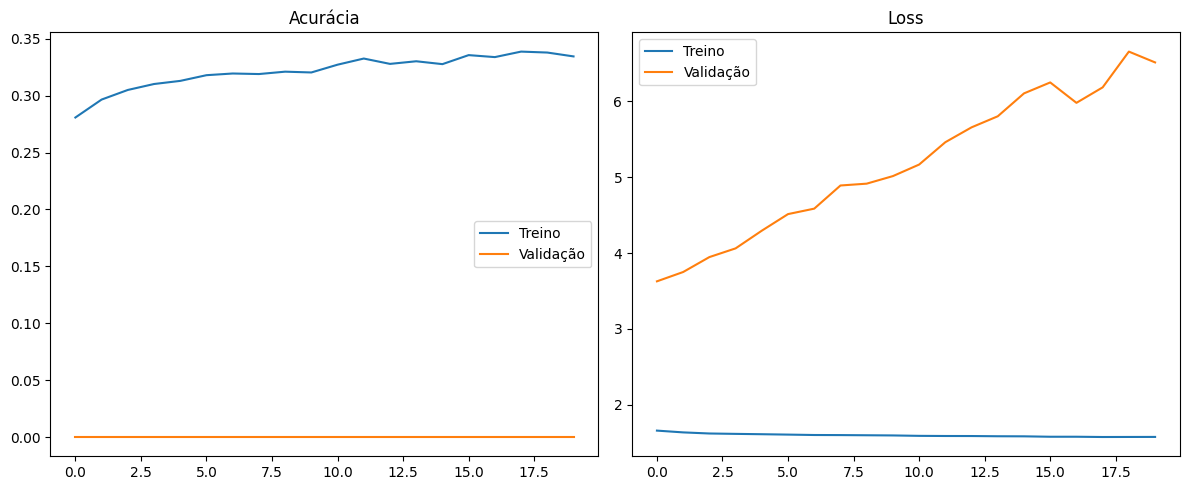

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Parâmetros ---
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(label_map)
EPOCHS = 30
BATCH_SIZE = 32

# --- One-hot encoding ---
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# --- Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# --- Dividir treino e validação ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_proc, y_train_cat, test_size=0.2, stratify=y_train, random_state=42
)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train_split, y_train_split, batch_size=BATCH_SIZE)

# --- Modelo com VGG19 base congelada ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

# --- Treinamento ---
history = model.fit(
    train_generator,
    validation_data=(X_val_split, y_val_split),
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    steps_per_epoch=len(X_train_split) // BATCH_SIZE
)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1578 - loss: 2.1765   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1395s 2s/step - accuracy: 0.1578 - loss: 2.1764 - val_accuracy: 0.1435 - val_loss: 1.9567 - learning_rate: 1.0000e-04
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 281s 391ms/step - accuracy: 0.0938 - loss: 2.2354 - val_accuracy: 0.1435 - val_loss: 1.9570 - learning_rate: 1.0000e-04
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1513 - loss: 2.0353   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.1513 - loss: 2.0352 - val_accuracy: 0.1620 - val_loss: 1.9497 - learning_rate: 1.0000e-04
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 281s 389ms/step - accuracy: 0.1562 - loss: 1.8437 - val_accuracy: 0.1609 - val_loss: 1.9497 - learning_rate: 1.0000e-04
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.1493 - loss: 1.9807 - val_accuracy: 0.1320 - val_loss: 1.9488 - learning_rate: 1.0000e-04
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 277s 385ms/step - accuracy: 0.2188 - loss: 1.6754 - val_accuracy: 0.1322 - val_loss: 1.9487 - learning_rate: 1.0000e-04
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.1550 - loss: 1.9653 - val_accuracy: 0.1012 - val_loss: 1.9425 - learning_rate: 1.0000e-04
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 276s 383ms/step - accuracy: 0.1562 - loss: 2.2790 - val_accuracy: 0.1008 - val_loss: 1.9425 - learning_rate: 1.0000e-04
Epoch 9/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1404s 2s/step - a

717/717 ━━━━━━━━━━━━━━━━━━━━ 1385s 2s/step - accuracy: 0.1819 - loss: 1.9305 - val_accuracy: 0.1701 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 20/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 18:09 2s/step - accuracy: 0.2188 - loss: 1.5805

717/717 ━━━━━━━━━━━━━━━━━━━━ 272s 377ms/step - accuracy: 0.2188 - loss: 1.5805 - val_accuracy: 0.1708 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 21/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1392s 2s/step - accuracy: 0.1903 - loss: 1.9117 - val_accuracy: 0.1379 - val_loss: 1.8968 - learning_rate: 1.0000e-04
Epoch 22/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 286s 398ms/step - accuracy: 0.0625 - loss: 1.7077 - val_accuracy: 0.1395 - val_loss: 1.8968 - learning_rate: 1.0000e-04
Epoch 23/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1661 - loss: 1.9326   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1398s 2s/step - accuracy: 0.1661 - loss: 1.9325 - val_accuracy: 0.2335 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 24/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 18:41 2s/step - accuracy: 0.1562 - loss: 2.1157

717/717 ━━━━━━━━━━━━━━━━━━━━ 284s 395ms/step - accuracy: 0.1562 - loss: 2.1157 - val_accuracy: 0.2346 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 25/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1392s 2s/step - accuracy: 0.1827 - loss: 1.9038 - val_accuracy: 0.1910 - val_loss: 1.8824 - learning_rate: 1.0000e-04
Epoch 26/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 271s 377ms/step - accuracy: 0.1250 - loss: 2.0148 - val_accuracy: 0.1907 - val_loss: 1.8823 - learning_rate: 1.0000e-04
Epoch 27/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.1894 - loss: 1.8959 - val_accuracy: 0.2252 - val_loss: 1.8788 - learning_rate: 1.0000e-04
Epoch 28/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 275s 381ms/step - accuracy: 0.2812 - loss: 1.6363 - val_accuracy: 0.2269 - val_loss: 1.8788 - learning_rate: 1.0000e-04
Epoch 29/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1324s 2s/step - accuracy: 0.1953 - loss: 1.8858 - val_accuracy: 0.2224 - val_loss: 1.8745 - learning_rate: 1.0000e-04
Epoch 30/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 261s 362ms/

In [5]:
import os
import cv2
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Caminho original
train_path = os.path.join(destination_path, "train")

# Contar imagens por classe
class_counts = {class_name: len(os.listdir(os.path.join(train_path, class_name)))
                for class_name in os.listdir(train_path)}
max_count = max(class_counts.values())

print("Distribuição original:", class_counts)

# Gerador com algumas transformações comuns
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Função para aumentar imagens de uma classe
def augment_class(class_name, target_count):
    class_dir = os.path.join(train_path, class_name)
    images = []

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)

    images = np.array(images)
    images = images.astype("float32") / 255.0  # Normaliza se necessário

    n_to_generate = target_count - len(images)
    generated = 0
    batch_size = 32

    # Gera imagens usando o generator
    for x_batch in datagen.flow(images, batch_size=batch_size, save_to_dir=class_dir,
                                save_prefix="aug", save_format="png"):
        generated += len(x_batch)
        if generated >= n_to_generate:
            break

# Aumentar classes minoritárias
for class_name, count in class_counts.items():
    if count < max_count:
        print(f"Aumentando classe '{class_name}' de {count} para {max_count}")
        augment_class(class_name, max_count)

Distribuição original: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Aumentando classe 'angry' de 3995 para 7215
Aumentando classe 'disgust' de 436 para 7215
Aumentando classe 'fear' de 4097 para 7215
Aumentando classe 'neutral' de 4965 para 7215
Aumentando classe 'sad' de 4830 para 7215
Aumentando classe 'surprise' de 3171 para 7215


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Inverter o mapeamento de labels
inv_label_map = {v: k for k, v in label_map.items()}

# Reaproveitar a função de distribuição
def get_distribution(labels):
    count_series = pd.Series(labels).value_counts().sort_index()
    count_df = pd.DataFrame({
        'Emoção': [inv_label_map[i].capitalize() for i in count_series.index],
        'Quantidade': count_series.values,
    })
    total = count_df['Quantidade'].sum()
    count_df['Porcentagem'] = (count_df['Quantidade'] / total * 100).round(2)
    return count_df

# Obter distribuição apenas do treino
df_train = get_distribution(y_train)

# Gráfico de barras (somente treino)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Emoção',
    y='Porcentagem',
    palette=['#4C72B0']
)

plt.title("Distribuição percentual de emoções - Conjunto de Treino", fontsize=14)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Emoção")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Transformar X e y em arrays e converter labels para one-hot
X_train_proc = np.array([preprocess_pipeline(img) for img in X_train])
X_test_proc = np.array([preprocess_pipeline(img) for img in X_test])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)

# Carrega a base do VGG19 sem a camada de classificação final
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congela as camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Adiciona as camadas finais customizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [
    #arlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Train shape: (50800, 224, 224, 3)
Test shape: (7178, 224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1720 - loss: 2.0226   

1270/1270 ━━━━━━━━━━━━━━━━━━━━ 2447s 2s/step - accuracy: 0.1721 - loss: 2.0225 - val_accuracy: 0.0000e+00 - val_loss: 3.7700
Epoch 2/20
  12/1270 ━━━━━━━━━━━━━━━━━━━━ 29:48 1s/step - accuracy: 0.1940 - loss: 1.8061  